# Tree Cover in Amazonia

## Overview

- **Key ideas:**
    - Intensive RAM Memory operations, run this notebook in aerossol server.
    - Understanding [MODIS sinusoidal tile grid](https://modis-land.gsfc.nasa.gov/MODLAND_grid.html).
    - Annual (2019 - 2020) tree cover in Part of Amazonia from [MOD44B v006: MODIS/Terra Vegetation Continuous Fields Yearly L3 Global 250 m SIN](https://lpdaac.usgs.gov/products/mod44bv006/) product.
    - Learning how to reproject MODIS data using [rioxarray package](https://corteva.github.io/rioxarray/stable/). 
    - From sinusoidal projection to a `coarser` latitude-longitude regular grid (0.01°x0.01°).

## Initial setup

In [1]:
# Load packages.
import sys
import glob
import os
import rioxarray
import warnings

import numpy as np
import xarray as xr
import geopandas as gpd

from matplotlib import pyplot as plt
from dask.diagnostics import ProgressBar
from matplotlib.lines import Line2D

# Better visualization.
xr.set_options(display_style="text")

# Without warning messages.
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
%%time

# My repository.
repository = "/work/sandroal/cdlearn/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Work in progress.
import cdlearn

CPU times: user 1.8 s, sys: 396 ms, total: 2.2 s
Wall time: 3.23 s


In [3]:
print("\n>>> Computer:")
!echo "* Hostname: ${HOSTNAME}"
!echo "* User: ${USER}"
!echo "* Directory: $(pwd)"
!echo "* Date: $(date)"
!echo "* CPUs: $(nproc)"


>>> Computer:
* Hostname: n008
* User: sandroal
* Directory: /work/sandroal/notebooks/single_variables
* Date: Thu Mar 18 19:52:42 BRT 2021
* CPUs: 40


In [4]:
# Data folder.
MAIN_FOLDER = "/work/sandroal/data_sets/MODIS/TREE_COVER/"

# Save figures here.
save_fig = True
FIG_FOLDER = "/work/sandroal/images/single_variables/"

## Load shape file for Amazonia

In [5]:
# Load all shape files.
gdf_amazonia = gpd.read_file(
    filename="/work/sandroal/data_sets/WORLD_MAP/AMAZON/amapoly_ivb.shp"
)

## Load shape files for protected areas inside Amazonia

In [6]:
%%time

# Source: /work/sandroal/scripts/protected_areas_inside_amazonia.py
PAS_FOLDER = "/work/sandroal/data_sets/PROTECTED_AREAS/AMAZONIA/"
gdf_pas_polygons = gpd.read_file(PAS_FOLDER + "polygons.shp")
gdf_pas_points = gpd.read_file(PAS_FOLDER + "points.shp")

CPU times: user 904 ms, sys: 100 ms, total: 1 s
Wall time: 1.01 s


## Explore some adjacent tiles

In [7]:
# Files paths.
FPS = sorted(glob.glob(MAIN_FOLDER + "*.hdf"))

# List all tiles for 2019-2020.
year = "2019"
[FP for FP in FPS if year + "065" in FP]

['/work/sandroal/data_sets/MODIS/TREE_COVER/MOD44B.A2019065.h09v07.006.2020098203247.hdf',
 '/work/sandroal/data_sets/MODIS/TREE_COVER/MOD44B.A2019065.h09v08.006.2020098203618.hdf',
 '/work/sandroal/data_sets/MODIS/TREE_COVER/MOD44B.A2019065.h09v09.006.2020098203228.hdf',
 '/work/sandroal/data_sets/MODIS/TREE_COVER/MOD44B.A2019065.h10v07.006.2020098203405.hdf',
 '/work/sandroal/data_sets/MODIS/TREE_COVER/MOD44B.A2019065.h10v08.006.2020098203124.hdf',
 '/work/sandroal/data_sets/MODIS/TREE_COVER/MOD44B.A2019065.h10v09.006.2020098203755.hdf',
 '/work/sandroal/data_sets/MODIS/TREE_COVER/MOD44B.A2019065.h10v10.006.2020098203025.hdf',
 '/work/sandroal/data_sets/MODIS/TREE_COVER/MOD44B.A2019065.h10v11.006.2020098203704.hdf',
 '/work/sandroal/data_sets/MODIS/TREE_COVER/MOD44B.A2019065.h11v07.006.2020098203421.hdf',
 '/work/sandroal/data_sets/MODIS/TREE_COVER/MOD44B.A2019065.h11v08.006.2020098202932.hdf',
 '/work/sandroal/data_sets/MODIS/TREE_COVER/MOD44B.A2019065.h11v09.006.2020098202823.hdf',

**MODIS TILES!**

![](./modis_tiles.jpg)

In [8]:
%%time

# Amazonia region 2019-2020 (see map above).
tiles = ["h10v09", "h11v09", "h12v09", "h10v10", "h11v10", "h12v10"]

# Get files for these tiles.
data_fps = [FP for FP in FPS for tile in tiles if (year + "065" in FP) and (tile in FP)]

# Read all these files (into memory).
DSs = []
for data_fp in data_fps:
    DSs.append(rioxarray.open_rasterio(data_fp, cache=True))

CPU times: user 3.05 s, sys: 256 ms, total: 3.3 s
Wall time: 3.53 s


In [9]:
# Data object for one of these tiles.
DSs[0]

<xarray.Dataset>
Dimensions:                     (band: 1, x: 4800, y: 4800)
Coordinates:
  * y                           (y) float64 -115.8 -347.5 ... -1.112e+06
  * x                           (x) float64 -8.895e+06 -8.895e+06 ... -7.784e+06
  * band                        (band) int64 1
    spatial_ref                 int64 0
Data variables:
    Percent_Tree_Cover          (band, y, x) uint8 ...
    Percent_NonTree_Vegetation  (band, y, x) uint8 ...
    Percent_NonVegetated        (band, y, x) uint8 ...
    Quality                     (band, y, x) uint8 ...
    Percent_Tree_Cover_SD       (band, y, x) uint16 ...
    Percent_NonVegetated_SD     (band, y, x) uint16 ...
    Cloud                       (band, y, x) uint8 ...
Attributes:
    ASSOCIATEDINSTRUMENTSHORTNAME.1:      MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:        Terra
    ASSOCIATEDSENSORSHORTNAME.1:          MODIS
    AUTOMATICQUALITYFLAG.1:               Passed
    AUTOMATICQUALITYFLAGEXPLANATION.1:    set Passed as default, will decide ...
    DAYNIGHTFLAG:                         Day
    DESCRREVISION:                        6.0
    EASTBOUNDINGCOORDINATE:               -69.9916666603812
    EXCLUSIONGRINGFLAG.1:                 N
    GRINGPOINTLATITUDE.1:                 -9.99999999910196, 0.00723066070579...
    GRINGPOINTLONGITUDE.1:                -81.23412894334, -80.0083693394496,...
    GRINGPOINTSEQUENCENO.1:               1, 2, 3, 4
    HDFEOSVersion:                        HDFEOS_V2.19
    HORIZONTALTILENUMBER:                 10
    identifier_product_doi:               10.5067/MODIS/MOD44B.006
    identifier_product_doi_authority:     http://dx.doi.org
    INPUTPOINTER:                         , MOD44CH.A2019065.h10v09.006.20190...
    LOCALGRANULEID:                       MOD44B.A2019065.h10v09.006.20200982...
    LOCALVERSIONID:                       SCF 5.1.3
    LONGNAME:                             MODIS/Terra Vegetation Continuous F...
    NORTHBOUNDINGCOORDINATE:              0.0
    OPERATIONALQUALITYFLAG.1:             Passed
    OPERATIONALQUALITYFLAGEXPLANATION.1:  set Passed as default, will decide ...
    PARAMETERNAME.1:                      MODIS/Terra Vegetation Continuous F...
    PGEVERSION:                           6.0.4
    PROCESSINGENVIRONMENT:                Linux minion7154 3.10.0-1062.12.1.e...
    PRODUCTIONDATETIME:                   2020-04-07T20:37:55.000Z
    QAPERCENTCLOUDCOVER.1:                0
    QAPERCENTGOODQUALITY:                 100
    QAPERCENTINTERPOLATEDDATA.1:          0
    QAPERCENTMISSINGDATA.1:               0
    QAPERCENTNOTPRODUCEDCLOUD:            0
    QAPERCENTNOTPRODUCEDOTHER:            0
    QAPERCENTOTHERQUALITY:                0
    QAPERCENTOUTOFBOUNDSDATA.1:           0
    RANGEBEGINNINGDATE:                   2019-03-06
    RANGEBEGINNINGTIME:                   00:00:00.000000
    RANGEENDINGDATE:                      2020-03-05
    RANGEENDINGTIME:                      00:00:00.000000
    REPROCESSINGACTUAL:                   reprocessed
    REPROCESSINGPLANNED:                  further update is anticipated
    SCIENCEQUALITYFLAG.1:                 Not Investigated
    SCIENCEQUALITYFLAGEXPLANATION.1:      See http://landweb.nascom.nasa.gov/...
    SHORTNAME:                            MOD44B
    SOUTHBOUNDINGCOORDINATE:              -9.99999999910196
    TileID:                               51010009
    VERSIONID:                            6
    VERTICALTILENUMBER:                   9
    WESTBOUNDINGCOORDINATE:               -81.23412894334

CPU times: user 1min 43s, sys: 2.74 s, total: 1min 46s
Wall time: 1min 46s


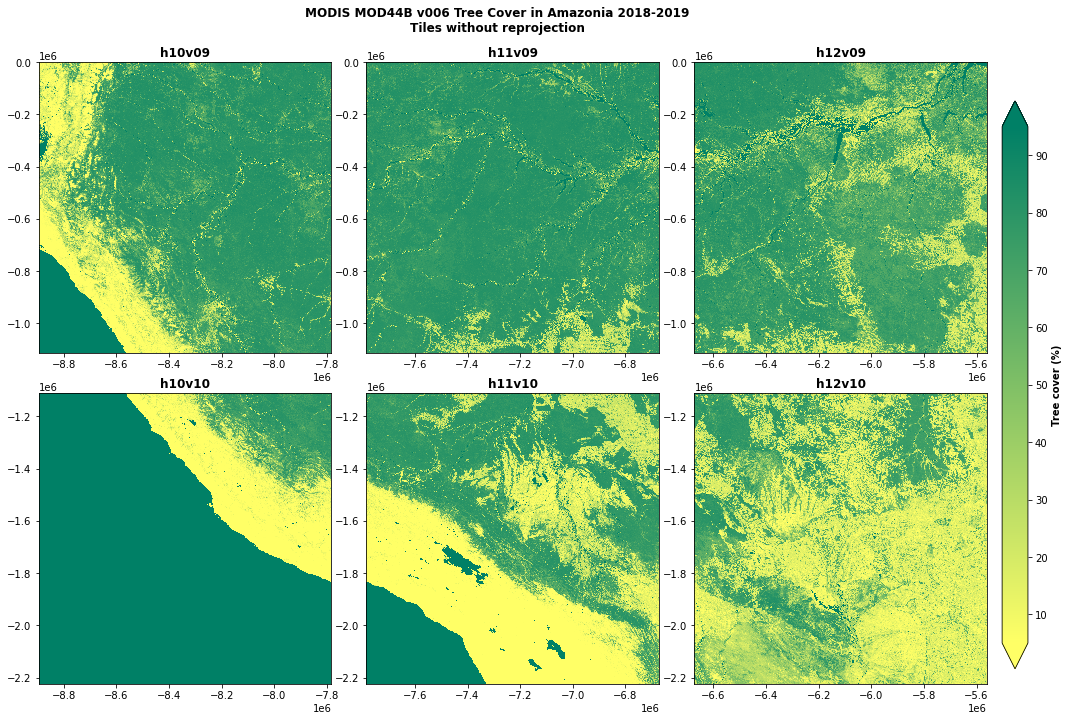

In [10]:
%%time

# Plot these tiles.
fig, axes = plt.subplots(2, 3, figsize=(17, 11))

# Plot data without reprojection.
index = 0
for j in range(axes.shape[1]):
    for i in range(axes.shape[0]):
        
        # Adjacent data in the subplots.
        plotmap = DSs[index].Percent_Tree_Cover.plot(
            ax=axes[i, j],
            vmin=5,
            vmax=95,
            cmap=plt.cm.summer_r,
            add_colorbar=False,
            add_labels=False
        )
        
        axes[i, j].set_title(np.array(tiles).reshape(2, 3)[i, j], weight="bold")
        index = index + 1
        
# Common color bar.
cb = plt.colorbar(
    mappable=plotmap,
    ax=axes,
    orientation="vertical",
    extend="both",
    shrink=0.95,
    anchor=(1.35, 0.5)
)
cb.set_label("Tree cover (%)", weight="bold")

# Adjustments.        
fig.suptitle("MODIS MOD44B v006 Tree Cover in Amazonia 2018-2019\nTiles without reprojection", 
             weight="bold")
plt.subplots_adjust(hspace=0.14, wspace=0.12, top=0.91)

if save_fig:
    plt.savefig(
        FIG_FOLDER + "tree_cover_modis_amazonia.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )     

## Combine and then reproject tree cover variable

In [11]:
%%time

# Read again the same tiles as before, but this time with lazy operations.
DSs = []
for data_fp in data_fps:
    DSs.append(
        rioxarray.open_rasterio(
            data_fp, 
            chunks={"x": 480, "y": 480},
            variable=["Percent_Tree_Cover"]
        ).sel(band=1)
    )
    
# Combine these tiles together.
DS = xr.combine_by_coords(datasets=DSs, combine_attrs="drop")

# Show it.
DS

CPU times: user 552 ms, sys: 84 ms, total: 636 ms
Wall time: 740 ms


<xarray.Dataset>
Dimensions:             (x: 14400, y: 9600)
Coordinates:
    spatial_ref         int64 0
    band                int64 1
  * x                   (x) float64 -8.895e+06 -8.895e+06 ... -5.56e+06
  * y                   (y) float64 -115.8 -347.5 ... -2.224e+06 -2.224e+06
Data variables:
    Percent_Tree_Cover  (y, x) uint8 dask.array<chunksize=(480, 480), meta=np.ndarray>

In [12]:
%%time

# Reproject data to a lat-lon grid with coarser resolution. 
res = 0.01
with ProgressBar():
    DS = DS.rio.reproject("epsg:4326", resolution=(res, res))

[########################################] | 100% Completed |  2.2s
CPU times: user 2.83 s, sys: 552 ms, total: 3.38 s
Wall time: 3.03 s


In [13]:
# Rename coordinates and dimensions.
DS = DS.rename(name_dict={"x": "lon", "y": "lat"})
DS

<xarray.Dataset>
Dimensions:             (lat: 2000, lon: 3514)
Coordinates:
  * lon                 (lon) float64 -85.13 -85.12 -85.11 ... -50.01 -50.0
  * lat                 (lat) float64 -0.005 -0.015 -0.025 ... -19.98 -20.0
    band                int64 1
    spatial_ref         int64 0
Data variables:
    Percent_Tree_Cover  (lat, lon) uint8 241 241 241 241 241 ... 241 241 241 241

In [14]:
# Put invalid data as not a numbers.
valid = DS.Percent_Tree_Cover <= 100
DS["Percent_Tree_Cover"] = DS.Percent_Tree_Cover.where(cond=valid==True, drop=True)
DS

<xarray.Dataset>
Dimensions:             (lat: 2000, lon: 3514)
Coordinates:
  * lon                 (lon) float64 -85.13 -85.12 -85.11 ... -50.01 -50.0
  * lat                 (lat) float64 -0.005 -0.015 -0.025 ... -19.98 -20.0
    band                int64 1
    spatial_ref         int64 0
Data variables:
    Percent_Tree_Cover  (lat, lon) float64 nan nan nan nan ... nan nan nan nan

CPU times: user 24.5 s, sys: 848 ms, total: 25.4 s
Wall time: 25.4 s


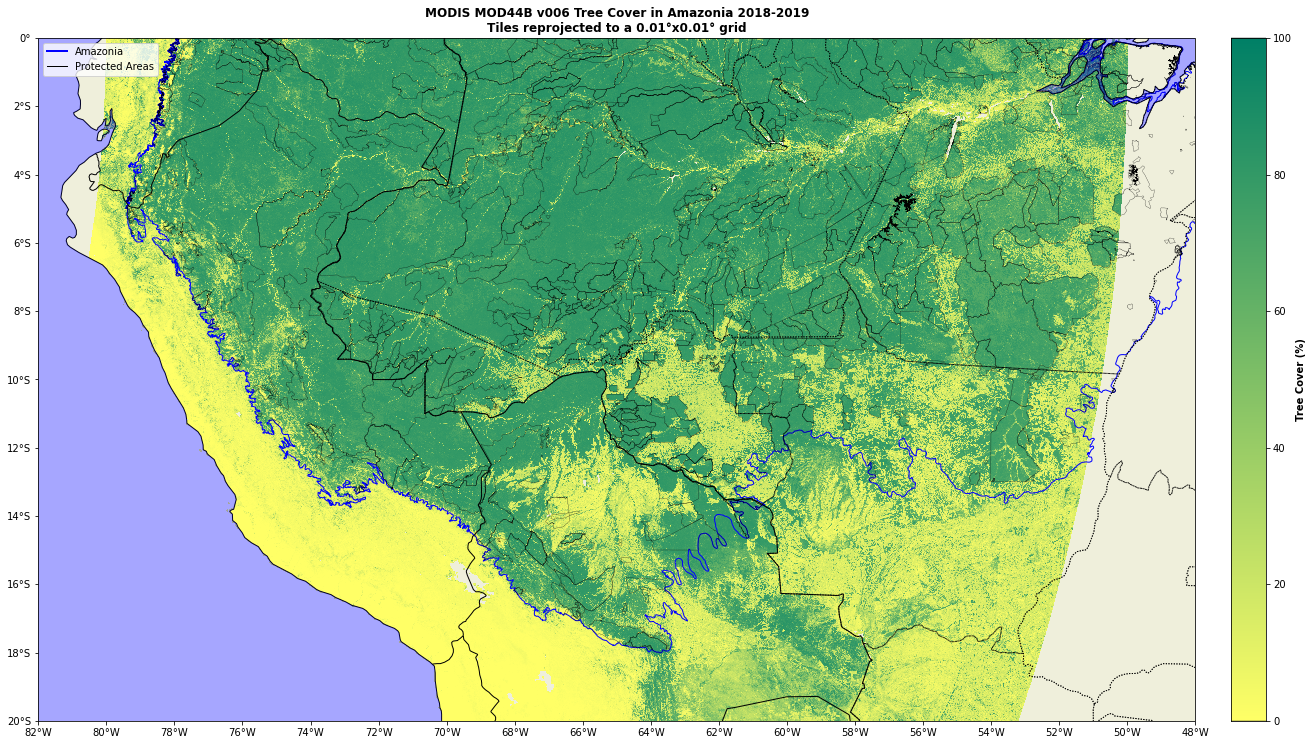

In [15]:
%%time

# Make map.
axgr = cdlearn.maps.general(
    figsize=(22, 22),
    region={"lati": int(DS.lat[-1] - 1), 
            "latf": int(DS.lat[0] + 1), 
            "loni": -82, 
            "lonf": int(DS.lon[-1] + 1)},
    region_ticks={"lat": 1, "lon": 1},
    grid_lines=False,
    dticks={"x": 2, "y": 2},
    brazilian_states=True,
    ocean=True
)

# Plot tree cover reprojected data.
plotmap = DS.Percent_Tree_Cover.plot(
    ax=axgr[0],
    vmin=0,
    vmax=100,
    cmap=plt.cm.summer_r,
    add_colorbar=False,
    add_labels=False
)

# Fill colorbar.        
cb = axgr.cbar_axes[0].colorbar(plotmap)
cb.set_label_text("Tree Cover (%)", weight="bold")

# Adjustments.        
axgr[0].set_title(
    "MODIS MOD44B v006 Tree Cover in Amazonia 2018-2019\nTiles reprojected to a " + \
    f"{res}°x{res}° grid", 
     weight="bold"
)

# Plot shapefiles.
for axis in axgr:
    
    # Border of Amazonia.
    gdf_amazonia.plot(
        ax=axis,
        facecolor="none",
        edgecolor="blue",
        ls="-",
        lw=1,
        legend=True
    )

    # Protected areas (Polygons).
    gdf_pas_polygons.plot(
        ax=axis,
        facecolor="none",
        edgecolor="black",
        ls="-",
        lw=0.25
    )

    # Legends for these shapefiles.
    legend_elements = [
        Line2D([0], [0], color="blue", ls="-", lw=2, label="Amazonia"),
        Line2D([0], [0], color="black", ls="-", lw=1, label="Protected Areas")
    ]
    axis.legend(handles=legend_elements, loc="upper left")

if save_fig:
    plt.savefig(
        FIG_FOLDER + "tree_cover_modis_amazonia2.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )     